In [7]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
def read_data(filepath: str, offset: int = 0, data_length: int = None, data_type: str ='int16') -> pd.DataFrame:
    """Фукнция для считывания данных из бинарных файлов

    Args:
        filepath (str): Путь до файла.
        offset (int, optional): Количество наблюдений, которое нужно пропустить сначала. Defaults to 0.
        data_length (int, optional): Необходимое количество наблюдений. Если не передавать никакого значения, будут считаны все данные, начиная с offset. Defaults to None.
        data_type (str, optional): Тип данных. Defaults to 'int16'.

    Returns:
        pd.DataFrame: Итоговая таблица. Столбцы right, top, left, bottom отвечают за данные с четырех пикапов.
    """

    # Считывание данных в один вектор
    line_data = np.fromfile(filepath, dtype=data_type)
    # Разделение вектора на четыре столбца матрицы, каждый из которых соответствует пикапу
    data = line_data.reshape(-1, 4)
    # Формирование датафрейма на основе предыдущей матрицы
    data = pd.DataFrame(data, columns=['right', 'top', 'left', 'bottom'])
    # Если не передано никакого значения в data_length, то будут браться все значение, начиная с offset
    if data_length is None: data_length = len(data) - offset
    # Из полученного датафрейма делается срез, начиная с offset, длинной data_length. в котором сбрасываются индесы (чтобы они начинались с нуля)
    data = data.iloc[offset: offset + data_length].reset_index().drop('index', axis=1)
    return data

In [9]:
def find_period_length_fft(data: np.ndarray, **kwargs) -> float:
    """Вычисление длины периода в заданном веторе данных.

    Args:
        data (np.ndarray): Вектор данных.
        **kwargs: Дополнительные ключевые аргументы - параметры для метода Фурье.
                Подробнее можно прочитать на https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fft.html#scipy-fft-fft

    Returns:
        float: Значение периода. Может получиться дробным.
    """

    # Применение прямого преобразования метода Фурье к данным
    yf = scipy.fft.fft(data, **kwargs)
    # Поиск индекса максимального значения в абсолютных величинах преобразованного вектора
    idx = np.argmax(np.abs(yf))
    # Нахождение длины периода, путем деления длины исходных данных на индекс максимального значения
    period = len(data)/idx
    return period

In [10]:
def get_beam_center_positions(summary_resonace: np.ndarray, difference_resonance: np.ndarray, period_length: float) -> np.ndarray:
    """Фукнция для вычисления координат центра масс по заданным суммарным и разностным резонансом для одной из осей.

    Args:
        summary_resonace (np.ndarray): Вектор суммарных резонансов по одной из осей.
        difference_resonance (np.ndarray): Вектор разностных резонансов по той же самой оси.
        period_length (float): Длина периода. Может быть дробной.

    Returns:
        np.ndarray: Вектор со значениями координаты центра масс для каждого из периодов по заданной оси.
    """

    # Вычисление общего количества периодов
    number_of_periods = int(len(summary_resonace) / period_length)
    # Задания вектора, с количеством элементов, равным числу периодов, для хранения полученных координат. Изначально заполнен нулями
    mass_center_positions = np.zeros(number_of_periods)
 
    # Запускаем цикл от 0 до number_of_periods-1 включительно с шагом 1. Грубо говоря, этим циклом мы пробегаемся по всем периодам
    for i in range(number_of_periods):

        # Находим срез, соответсвующий текущему периоду, для векторов summary_resonance и difference_resonance.
        # ВАЖНАЯ ДЕТАЛЬ. В данном случае, вручную задается тип int64, так как происходит переполнение изначального типа int16 при возведении значений в квадрат
        summary_resonance_period_slice = np.array(summary_resonace, 'int64')[int(i*period_length): int((i+1)*period_length)] 
        difference_resonance_period_slice = np.array(difference_resonance, 'int64')[int(i*period_length): int((i+1)*period_length)] 
 
        # Вычисление промежуточных параметров. Автор не особо осведомлен об их природе, поэтому тут могут потребоваться дополнительные пояснения
        m_11 = float(np.sum(summary_resonance_period_slice**2))
        m_12 = float(np.sum(summary_resonance_period_slice)) 
 
        y_1 = float(summary_resonance_period_slice @ difference_resonance_period_slice) 
        y_2 = float(np.sum(difference_resonance_period_slice)) 

        # Вычисление значения координаты центра масс для текущего периода. Добавление ее в итоговый вектор
        mass_center_positions[i] = ((m_12 * y_2) - (np.floor(period_length) * y_1)) / (m_12 ** 2 - m_11 * np.floor(period_length)) 
 
    return mass_center_positions

In [11]:
# WARNING!!! Данная функция пока еще не была протестирована для правой части спектра
def get_spectrum(beam_center_coordinates: np.ndarray, number_of_samples: int = 2**8, offset: int = 3, is_left_part: bool = True) -> tuple:
    """Функция для нахождения спектра дробной части бетатронной частоты.

    Args:
        beam_center_coordinates (np.ndarray): Вектор координат центров масс пучка по одной из осей.
        number_of_samples (int, optional): _description_. Число отсчетов для дискретного преобразования Фурье. Для корректной работы должно быть степенью двойки. Defaults to 2**8.
        offset (int, optional): _description_. Количество частот, которые мы пропускаем сначала (т.е. считаем их амплитуду нулевой). Defaults to 3.
        is_left_part (bool, optional): _description_. Флаг, отвечающий за интересующую часть спектра. Если True - берется левая часть спектра (частота меньше 0.5).
            Если False - правая (частота больше 0.5). Defaults to True.

    Returns:
        tuple: Возвращает кортеж с двумя векторами типов np.ndarray: frequences - значения частот, amplitudes - значения соответствующих им амплитуд.
    """

    # Применяем прямое преобразование Фурье для первый number_of_samples координат центров масс. Для получения нужной нормировки, делим на number_of_samples
    fourier_transformed_vector = scipy.fft.fft(np.array(beam_center_coordinates)[:number_of_samples]) / number_of_samples
    # Заполняем первые offset значений нулями и оставляем только первую половину значений от преобразованного вектора. В дальнейшем, если будет нужна правая часть, это преобразуется
    sliced_fourier_transformed_vector = np.concatenate([np.zeros(offset), fourier_transformed_vector[3: number_of_samples // 2]])
    # Находим амплитуды сигналов, находя абсолютные значения для каждой из величин преобразованного вектора
    amplitudes = np.abs(sliced_fourier_transformed_vector)

    # С помощью данного ветвления происходит выбор между правой и левой частями спектра
    if is_left_part:
        # Если левая часть спектра, то частоты берутся от 0 до 0.5
        frequences = np.arange(0, 0.5, 1 / number_of_samples)
    else:
        # WARNING!!! Данная часть не тестировалась. Возможные ошибки:
        # 1. Неправильный порядок частот или амплитуд. Можно попытаться отразить порядок следования элементов в массиве. Например, amplitudes = amplitudes[::-1].
        # 2. Небольшое смещение частот. Для этого, при расчете frequences нужно убрать слагаемое "+ 1 / number_of periods"

        # Если правая часть спектра, то сначала нужно преобразовать амплитуды
        amplitudes = 1 - amplitudes
        # Частоты берутся от 0.5 до 1
        frequences = np.arange(0.5, 1, 1 / number_of_samples) + 1 / number_of_samples

    return frequences, amplitudes

In [12]:
def find_main_frequence(frequences: np.ndarray, amplitudes: np.ndarray, slice_percentage: float = 0.5) -> float:
    """Функция для нахождения основной частоты спектра.

    Args:
        frequences (np.ndarray): Вектор частот спектра.
        amplitudes (np.ndarray): Вектор амплитуд спектра.
        slice_percentage (float, optional): Параметр, отвечающий за долю значений, которые будут расматриваться (автор не до конца в этом уверен)/
            По умолчанию, берутся все значения. Defaults to 0.5.

    Raises:
        ValueError: Возникает, если frequences и amplitudes имеют разную длину.

    Returns:
        float: Значение основной частоты
    """

    # Проверка на соответствие длин frequences и amplitudes. При несоответсвии выдается исключение
    if len(frequences) != len(amplitudes):
        raise ValueError('frequences and amplitudes must have same length')
    
    # Находим позицию, на которой находится значение максимальной из амплитуд вместе с соотвествующим срезом (умножение на двойку было в маткадовском коде,
    # если его убрать, то значение по умолчанию для slice_percentage нужно сделать равным единице).
    main_frequence_index = np.argmax(amplitudes[:int(slice_percentage * 2 * len(frequences))])
    # Выделяем частоту, которая находится на найденной выше позиции.
    main_frequence = frequences[main_frequence_index]
    return main_frequence

In [13]:
sns.set_theme()

In [14]:
offset = 8 * 6300 // 2 // 4
len_data = 4 * 1024**2 // 4

In [15]:
data = read_data(r'bpm_data/11_01_booster_libera08_hbpm3_1_full', offset=offset, data_length=len_data)
data

,right,top,left,bottom
0,-147,-273,-406,79
1,-157,-196,-416,321
2,17,-124,-416,383
3,373,-29,-415,230
4,247,-82,-421,-149
...,...,...,...,...
1048571,496,365,32,438
1048572,526,141,228,682
1048573,614,271,132,356
1048574,486,376,130,-11


In [16]:
summary_resonance = pd.DataFrame()
summary_resonance['X'] = data['right'] + data['left']
summary_resonance['Y'] = data['top'] + data['bottom']

difference_resonance = pd.DataFrame()
difference_resonance['X'] = data['right'] - data['left']
difference_resonance['Y'] = data['top'] - data['bottom']

In [17]:
period = find_period_length_fft(summary_resonance['X'])
period

2126.9290060851927

In [18]:
plate_size = {}
plate_size['X'] = 64
plate_size['Y'] = 33

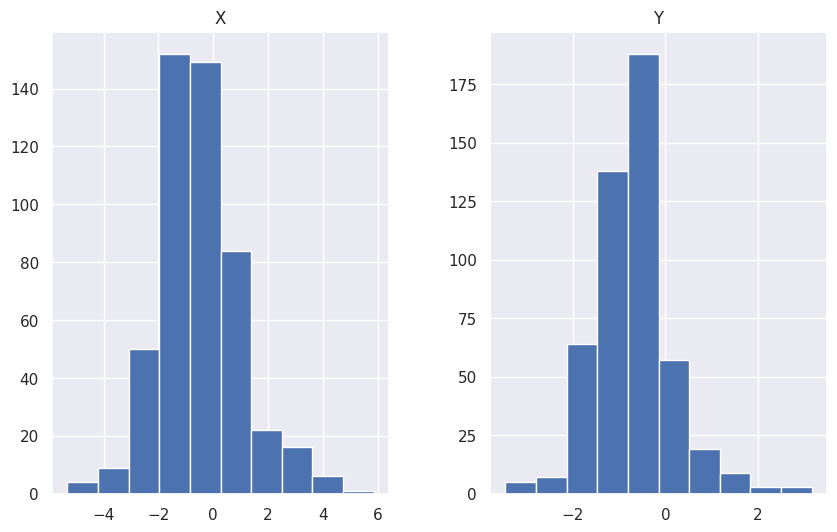

In [20]:
beam_center_coords = pd.DataFrame()
for axis in ['X', 'Y']:
    beam_center_coords[axis] = plate_size[axis] * get_beam_center_positions(summary_resonance[axis], difference_resonance[axis], period)
beam_center_coords.hist(figsize = (10, 6));

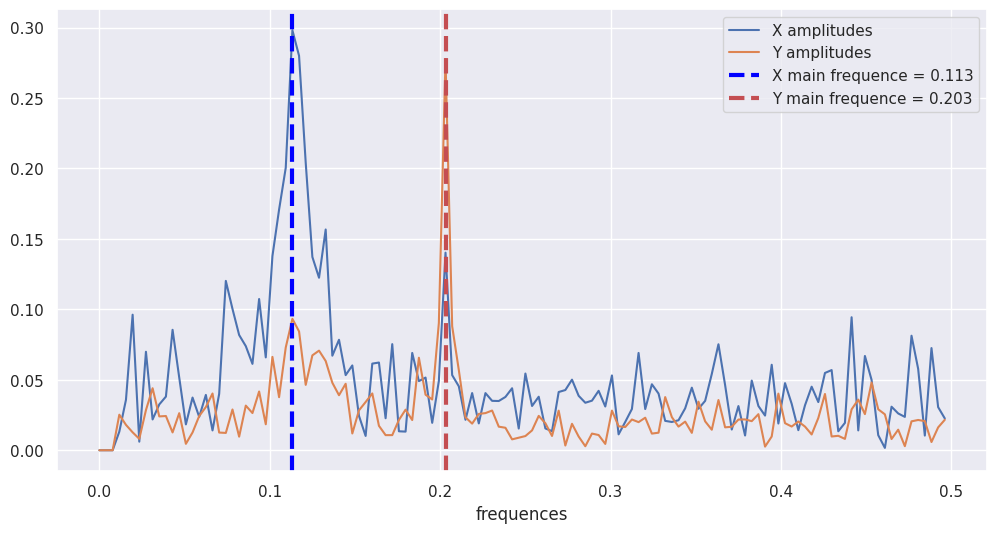

In [21]:
spectrum = pd.DataFrame()
main_frequences = {}
for axis in 'X', 'Y':
    freq, amp = get_spectrum(beam_center_coords[axis])
    spectrum[axis + ' amplitudes'] = amp
    main_frequences[axis] = find_main_frequence(freq, amp) 
spectrum['frequences'] = freq
spectrum = spectrum.set_index('frequences')

spectrum.plot(figsize=(12, 6))
plt.axvline(main_frequences['X'], ls='--', c='blue', lw=3, label=f'X main frequence = {round(main_frequences["X"], 3)}')
plt.axvline(main_frequences['Y'], ls='--', c='r', lw=3, label=f'Y main frequence = {round(main_frequences["Y"], 3)}')
plt.legend();

In [95]:
def correct_tune(coordinates, Q_0, delta_Q, number_of_periods, number_of_samples: int = 2**8):
    if number_of_periods > len(coordinates):
        raise ValueError("Number of periods can't be greater than length of coordinate vector")
    
    coordinates = np.array(coordinates)
    Q_p = Q_0 + delta_Q * (2 * np.arange(number_of_periods + 1) / number_of_periods - 1)
    ### 1j означает мнимую единицу!!!
    A_p = np.fromiter((coordinates[:number_of_periods] @ np.exp(2 * 1j * np.pi * Q_p[i] * np.arange(number_of_periods))
                       for i in range(number_of_periods+1)), 'complex')
    
    p = np.argmax(A_p)
    
    p_left_all = np.where(np.abs(A_p[p::-1]) < 0.5*np.abs(A_p[p]))
    p_left = p_left_all[0] if p_left_all else 0

    p_right_all = np.where(np.abs(A_p[p:]) < 0.5*np.abs(A_p[p]))
    p_right = p_right_all[0] if p_right_all else len(A_p) - 1

    csi = np.arange(p_left, p_right+1) - 0.5 * (p_left + p_right)

    M4 = np.sum(csi**4)
    M2 = np.sum(csi**2)
    Y2 = csi**2 @ np.abs(A_p[p_left:p_right+1])
    Y1 = csi @ np.abs(A_p[p_left:p_right+1])
    Y = np.sum(np.abs(A_p[p_left:p_right+1]))

    p_opt = (p_left + p_right) / 2 - Y1 / (2 * M2) * (M2**2 - M4 * (p_right - p_left + 1)) / (M2 * Y - (p_right - p_left +1 ) * Y2)

    Q = Q_0 * delta_Q * (2 * p_opt - number_of_periods) / number_of_periods

    a = (M2 * Y - (p_right - p_left + 1) * Y2) / (M2**2 - M4 * (p_right - p_left + 1))

    b = Y1 / M2

    c = - (M4 * Y - M2 * Y2) / (M2**2 - M4 * (p_right - p_left + 1))

    return c

In [96]:
a = [1, 2, 3 ,4]
a[2::-1]

[3, 2, 1]

In [97]:
correct_tune(beam_center_coords['X'], 3, 0.1, 34)

(array([1]), array([17]))

In [76]:
np.exp(2 * 1 * np.pi * 227 * 0.2)

7.680207059631165e+123

In [89]:
list(range(3, -1, -1))

[3, 2, 1, 0]

In [23]:
CorrectTune([1, 3, 5 ,2 , 4], 3, 34, 0.1)

array([2.9       , 2.90588235, 2.91176471, 2.91764706, 2.92352941,
       2.92941176, 2.93529412, 2.94117647, 2.94705882, 2.95294118,
       2.95882353, 2.96470588, 2.97058824, 2.97647059, 2.98235294,
       2.98823529, 2.99411765, 3.        , 3.00588235, 3.01176471,
       3.01764706, 3.02352941, 3.02941176, 3.03529412, 3.04117647,
       3.04705882, 3.05294118, 3.05882353, 3.06470588, 3.07058824,
       3.07647059, 3.08235294, 3.08823529, 3.09411765, 3.1       ])

In [ ]:
def CorrectTune(coordinate_vector, Q_0, N_p, delta_Q):
    
    N_t = 256
    Q_p = np.zeros(N_p + 1)
    A_p = []
    csi = []
 
    for i in range(N_p+1):
        Q_p[i] = Q_0 + delta_Q * ((2 * i - N_p) / N_p)
        for k in range(N_t):
            A_p[i] = x[k] * np.exp(2 * i * np.pi * Q_p[i] * k)
    return Q_p

In [ ]:
def CorrectTune(coordinate_vector, Q_0, N_p, delta_Q):
    
    N_t = 256
    Q_p = []
    A_p = []
    csi = []
 
    for i in range(N_p+1):
        Q_p[i] = Q_0 + delta_Q * ((2 * i - N_p) / N_p)

        for k in range(N_t):
            A_p[i] = x[k] * np.exp(2 * i * np.pi * Q_p[i] * k)
    
    p = np.argmax(A_p[:N_p+1])

    for p1 in range(0, p+1, -1):
        if np.abs(A_p[p1]) < 0.5 * np.abs(A_p[p]):
            p_1 = p1
            break

    for p2 in range(p, N_p):
        if np.abs(A_p[p2]) < 0.5 * np.abs(A_p[p]):
            p_2 = p2
            break

    for n in range(p_1, p_2+1):
        csi[n] = n - 0.5 * (p_1 + p_2)

    M4, M2, Y2, Y1, Y = 0, 0, 0, 0, 0

    for k in range(p_1, p_2+1):
        M4 += csi[k]**2
        M2 += csi[k]**2
        Y2 += csi[k]**2 * np.abs(A_p[k])
        Y1 += csi[k]* np.abs(A_p[k])
        Y += np.abs(A_p[k])

    p_opt = (p_1 + p_2) / 2 - Y1 / (2 * M2) * (M2**2 - M4 * (p_2 - p_1 + 1)) / (M2 * Y - (p_2 - p_1 +1 ) * Y2)

    Q = Q_0 * delta_Q * (2 * p_opt - N_p) / N_p

    a = (M2 * Y - (p_2 - p_1 + 1) * Y2) / (M2**2 - M4 * (p_2 - p_1 + 1))

    b = Y1 / M2

    c = - (M4 * Y - M2 * Y2) / (M2**2 - M4 * (p_2 - p_1 + 1))